In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, AnyMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[list[AnyMessage], add_messages]
    number_of_steps: int

In [19]:
import datasets
from langchain.docstore.document import Document

# Load the dataset
guest_dataset = datasets.load_dataset("agents-course/unit3-invitees", split="train")

# Convert dataset entries into Document objects
docs = [
    Document(
        page_content="\n".join([
            f"Name: {guest['name']}",
            f"Relation: {guest['relation']}",
            f"Description: {guest['description']}",
            f"Email: {guest['email']}"
        ]),
        metadata={"name": guest["name"]}
    )
    for guest in guest_dataset
]

In [ ]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.tools import tool

bm25_retriever = BM25Retriever.from_documents(docs)

@tool
def retrieve_guest(query: str) -> str:
    """Retrieves detailed information about gala guests based on their name or relation.
    Args:
        query (str): The name or relation of the guest to search for.
    Returns:
        str: Detailed information about the guest, including name, relation, description, and email.
    """
    results = bm25_retriever.invoke(query)
    if results:
        return "\n\n".join([doc.page_content for doc in results[:3]])
    else:
        return "No matching guest information found."

In [25]:
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

@tool
def triple(num: float) -> float:
    """
    Multiplies the input number by 3.
    Args:
        num (float): The input number.
    Returns:
        float: The result of multiplying the input number by 3.
    """
    return 3 * float(num)

@tool
def add(num1: float, num2: float) -> float:
    """
    Adds two numbers together.
    Args:
        num1 (float): The first number.
        num2 (float): The second number.
    Returns:
        float: The sum of the two numbers.
    """
    return float(num1) + float(num2)

@tool
def blame_someone(name: str) -> str:
    """
    Blames someone.
    Args:
        name (str): The name of the person to blame.
    Returns:
        str: A message blaming the person.
    """
    return f"{name} is such a dumbass."

tools = [TavilySearch(max_results=1), triple, add, blame_someone, retrieve_guest]

system_prompt = SystemMessage(
    """
    You are a reasoning agent designed to solve problems by selecting and using tools when needed.

    You have access to the following tools:
    - tavily_search: Useful for searching up-to-date information.
    - triple: Multiplies a number by 3.
    - add: Adds two numbers.
    - blame_someone: Finds someone to blame.

    Your job is to:
    1. Think step-by-step about how to solve the user's request.
    2. If a tool is needed, decide **which tool** is best and provide the **correct arguments** for it.

    The system will automatically call the tool for you — you do not need to write code or JSON.
    Just make sure to:
    - Select the correct tool.
    - Provide the correct arguments (matching the function schema).
    - Only request one tool at a time.
    - After receiving the result, continue reasoning.

    Once you have enough information, respond with:

    Final Answer: <your final answer here>

    Be precise, concise, and always follow this reasoning loop:
    Thought → [Tool Call if needed] → Observation → Repeat or Final Answer.
    """
)

inference_server_url = "http://localhost:8000/v1"

llm = ChatOpenAI(
    model="unsloth/Qwen3-14B-unsloth-bnb-4bit",
    openai_api_key="binhphap5",
    openai_api_base=inference_server_url,
    max_tokens=1024,
    temperature=0.6,
    top_p=0.95,
    verbose=True,
).bind_tools(tools=tools, tool_choice="auto")

In [26]:
tools

[TavilySearch(max_results=1, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 StructuredTool(name='triple', description='Multiplies the input number by 3.\nArgs:\n    num (float): The input number.\nReturns:\n    float: The result of multiplying the input number by 3.', args_schema=<class 'langchain_core.utils.pydantic.triple'>, func=<function triple at 0x7fd010042680>),
 StructuredTool(name='add', description='Adds two numbers together.\nArgs:\n    num1 (float): The first number.\n    num2 (float): The second number.\nReturns:\n    float: The sum of the two numbers.', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x7fd010042f80>),
 StructuredTool(name='blame_someone', description='Blames someone.\nArgs:\n    name (str): The name of the person to blame.\nReturns:\n    str: A message blaming the person.', args_schema=<class 'langchain_core.utils.pydantic.blame_someone'>, func=<function blame_someone at 0x7fd0100432e0>),
 Stru

In [27]:
from langgraph.prebuilt import ToolNode, tools_condition

# Define the node that calls the model
def call_model(
    state: AgentState
):
    response = llm.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [28]:
from langgraph.graph import StateGraph, START, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as agent. This means that this node is the first one called 
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use 'agent'.
    # This means these are the edges taken after the 'agent' node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next
    tools_condition,
)

# We now add a normal edge from 'tools' to 'agent'.
# This means that after 'tools' is called, 'agent' node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

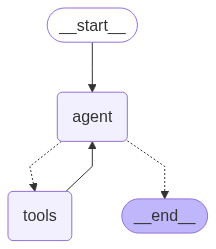

In [29]:
graph

In [35]:
inputs = {"messages": [{"type": "system", "content": system_prompt.content},
                       {"type": "human", "content": 
                       "Find the release year of a song named 'Unravel' in 'Tokyo Ghoul'. Then triple that value, then add 5 to the output value."
                       " Finally, blame a person named 'Pham Phong Phu'. Also let me know about how many guests that I have a strong relation with."
                       " Then, conclude with a final answer. /no_think"}],}
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

Find the release year of a song named 'Unravel' in 'Tokyo Ghoul'. Then triple that value, then add 5 to the output value. Finally, blame a person named 'Pham Phong Phu'. Also let me know about how many guests that I have a strong relation with. Then, conclude with a final answer. /no_think
================================== Ai Message ==================================

<think>

</think>

Thought: First, I need to find the release year of the song "Unravel" from "Tokyo Ghoul." Since this is a specific piece of information, I will use the `tavily_search` tool to search for the release year of the song.
Tool Calls:
  tavily_search (chatcmpl-tool-a7f70e8a26e14920b6dcf47893f1d9ef)
 Call ID: chatcmpl-tool-a7f70e8a26e14920b6dcf47893f1d9ef
  Args:
    query: release year of song 'Unravel' in 'Tokyo Ghoul'
================================= Tool Message =================================
Name: tavily_search

{"quer